In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats as sm_stat
import statsmodels.tsa as smt
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

In [ ]:
dataset = pd.read_csv('Traffic.csv')
dataset.head()
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:,1].values
print(dataset)

               DateTime  Junction  Vehicles           ID
0      01-11-2015 00:00         1        15  20151101001
1      01-11-2015 01:00         1        13  20151101011
2      01-11-2015 02:00         1        10  20151101021
3      01-11-2015 03:00         1         7  20151101031
4      01-11-2015 04:00         1         9  20151101041
...                 ...       ...       ...          ...
48115  30-06-2017 19:00         4        11  20170630194
48116  30-06-2017 20:00         4        30  20170630204
48117  30-06-2017 21:00         4        16  20170630214
48118  30-06-2017 22:00         4        22  20170630224
48119  30-06-2017 23:00         4        12  20170630234

[48120 rows x 4 columns]


In [ ]:
dataset["DateTime"] = pd.to_datetime(dataset["DateTime"])
dataset = dataset.drop(["ID"], axis = 1)

Text(0.5, 0, 'Date')

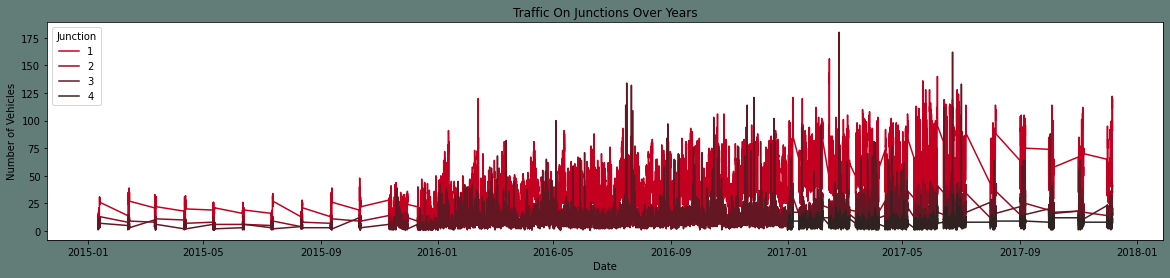

In [ ]:
df_ln1=dataset.copy() 
#Let's plot the Timeseries
colors = sns.dark_palette("#C40020" , "#1DC400" , "#00BAC4" , "#00BAC4")
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df_ln1['DateTime'],y="Vehicles",data=df_ln1, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [ ]:
df_ln1["Year"]= df_ln1['DateTime'].dt.year
df_ln1["Month"]= df_ln1['DateTime'].dt.month
df_ln1["Date_no"]= df_ln1['DateTime'].dt.day
df_ln1["Hour"]= df_ln1['DateTime'].dt.hour
df_ln1["Day"]= df_ln1.DateTime.dt.strftime("%A")
df_ln1.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-01-11 00:00:00,1,15,2015,1,11,0,Sunday
1,2015-01-11 01:00:00,1,13,2015,1,11,1,Sunday
2,2015-01-11 02:00:00,1,10,2015,1,11,2,Sunday
3,2015-01-11 03:00:00,1,7,2015,1,11,3,Sunday
4,2015-01-11 04:00:00,1,9,2015,1,11,4,Sunday


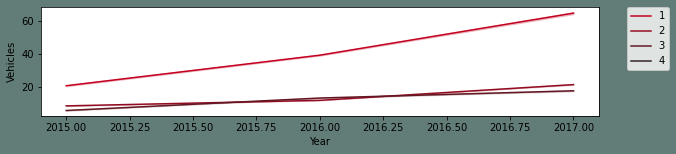

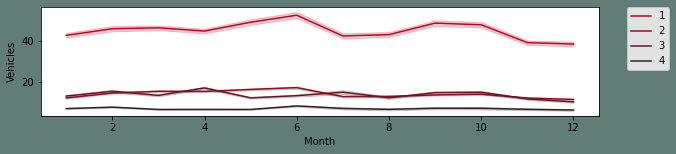

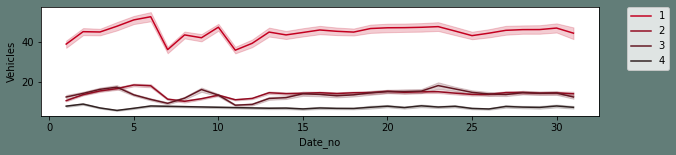

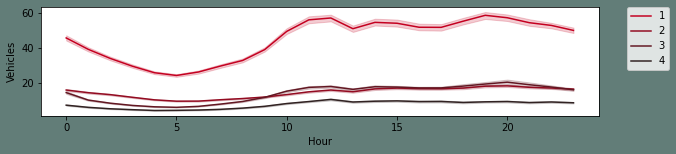

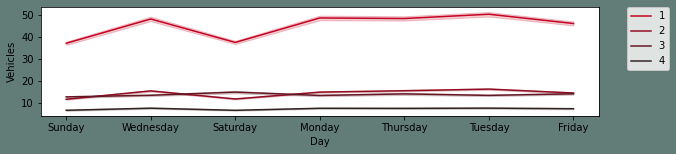

In [ ]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df_ln1[i],y="Vehicles",data=df_ln1, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
from sklearn.model_selection import train_test_split
X = dataset[["Junction"]]
Y = dataset[['Vehicles']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/2, random_state=0)

In [ ]:
# Step 3: Fit Simple Linear Regression to Training Data
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Step 4: Make Prediction
y_pred = regressor.predict(X_test)
arr = np.array(y_pred)
print(arr)

[3. 2. 2. ... 1. 2. 1.]


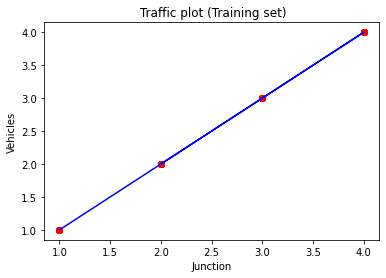

In [ ]:
# Step 5 - Visualize training set results
import matplotlib.pyplot as plt
#plot the actual data points of training set
plt.scatter(X_train, y_train, color = 'red')
#plot the regression line
plt.plot(X_train, regressor.predict(X_train), color='blue')
plt.title(' Traffic plot (Training set)')
plt.xlabel('Junction')
plt.ylabel('Vehicles')
plt.show()

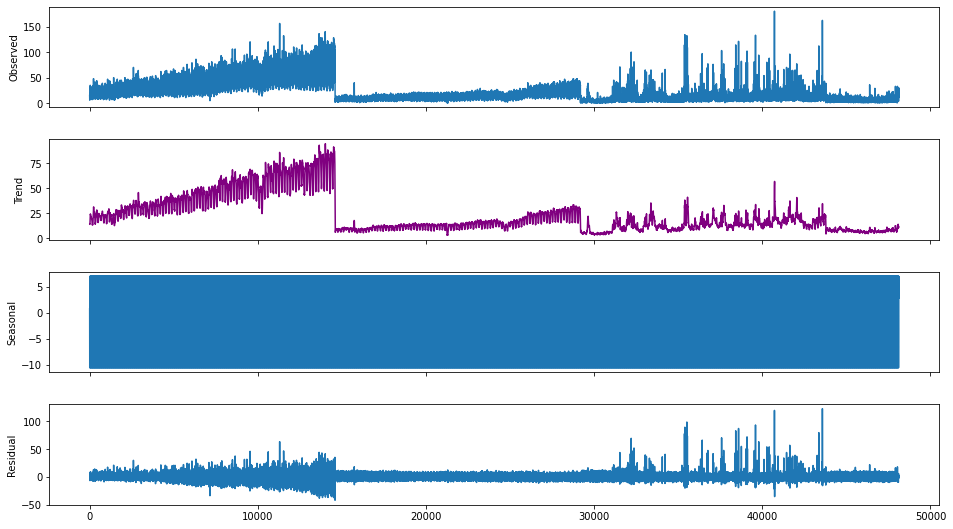

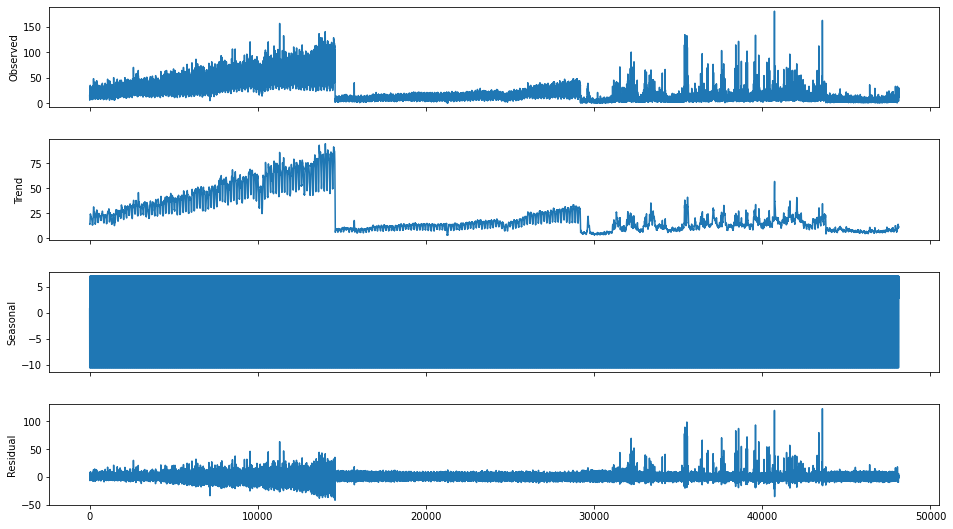

In [ ]:
df_ln1= dataset[['Vehicles']].copy()
df_ln2 =  dataset[['Vehicles']].copy()
res = sm.tsa.seasonal_decompose(df_ln1, freq = 24)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
for i in range(4):
    ax= fig.get_axes()[1]
    li=ax.get_lines()
    li[0].set_color('purple')
res1 = sm.tsa.seasonal_decompose(df_ln2, freq = 24)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [ ]:
# Split Data
df_ln1 = dataset[['Vehicles']].copy()
X,y = df_ln1.values, df_ln1. index
size = int(len(X)*0.85)
train_X, test_X, train_y, test_y = X[0:size], X[size:len(X)], y[0:size], y[size:len(y)]

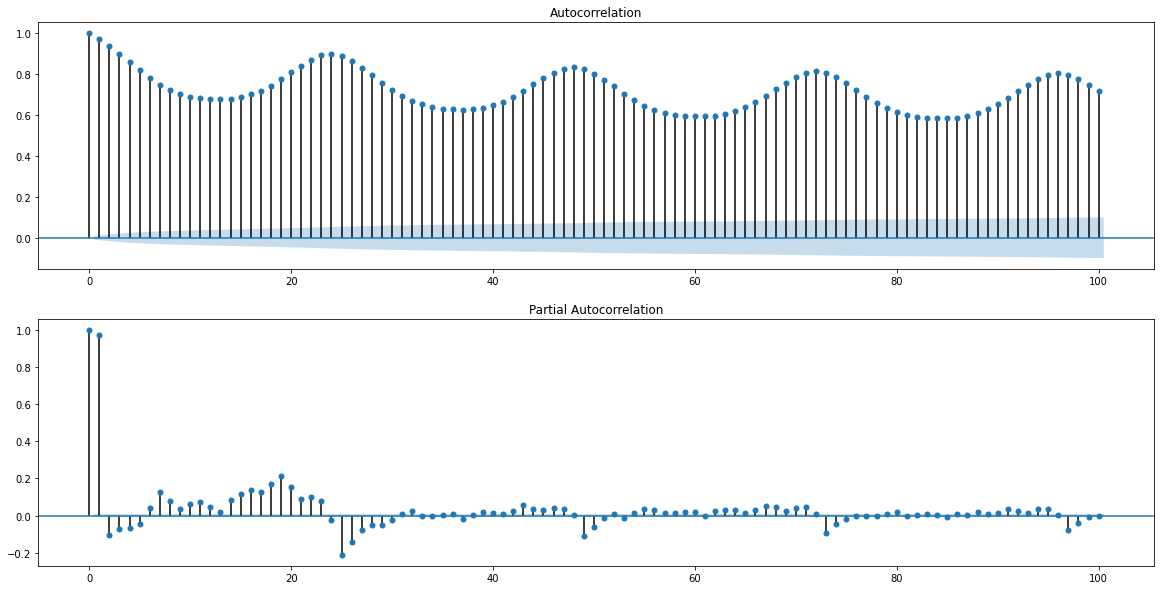

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train_X, lags = 100, ax=ax[0])
fig=sm.graphics.tsa.plot_pacf(train_X, lags = 100, ax=ax[1])
plt.show()

In [ ]:
#Create a differenced series
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
# invert differenced values
def inverse_difference(history, yhat, interval = 1):
    return yhat + history[ -interval]
# Seasonal differenced
interval = 24
differenced = difference(train_X, interval)

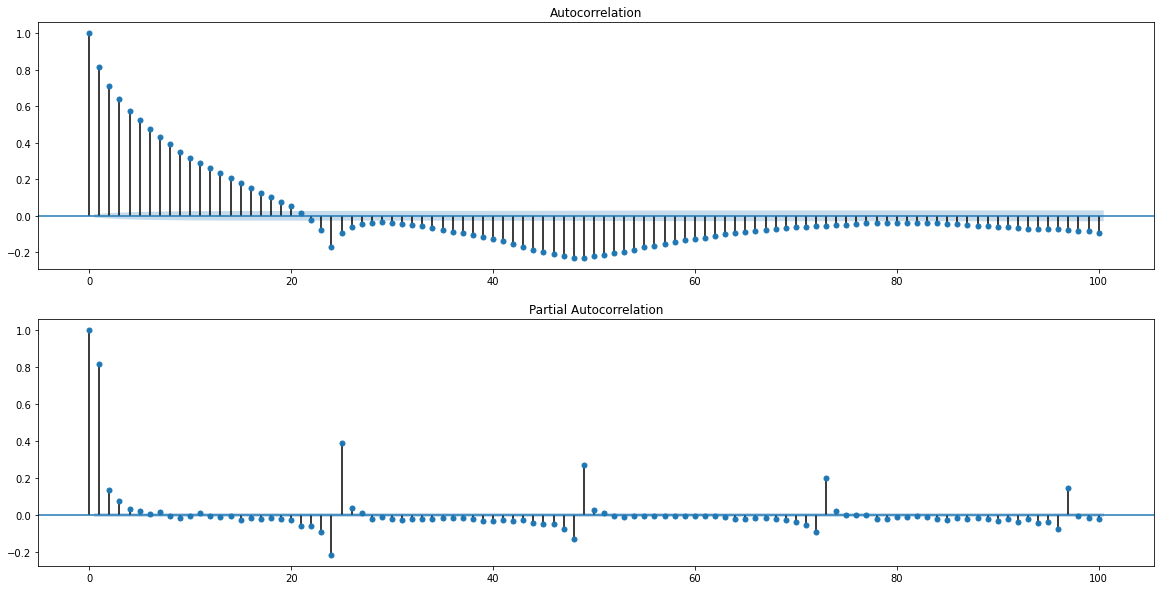

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(differenced, lags = 100, ax = ax[0])
fig = sm.graphics.tsa.plot_pacf(differenced, lags = 100, ax = ax[1])
plt.show()

In [ ]:
import statsmodels.api as sm
resDiff = sm.tsa.arma_order_select_ic(train_X, max_ar=5, max_ma=5, ic='aic', trend = 'c')
print('ARMA(p,q)=', resDiff['aic_min_order'], 'is the best.')

ARMA(p,q)= (4, 5) is the best.


In [ ]:
#fit arma_order_select_ic
model = sm.tsa. ARIMA(differenced, order=(4,0,4))
model_fit =  model.fit(disp=0)
# multi-step out of sample forecast
step = 60
start_index = len(differenced)
end_index = start_index + step
forecast = model_fit.predict(start =  start_index, end = end_index)
# invert the differenced forecast to something usable
history = [x for x in train_X]
prediction = []
for yhat in forecast:
    inverted = inverse_difference(history, yhat, interval)
    history.append(inverted)
    prediction.append(inverted)

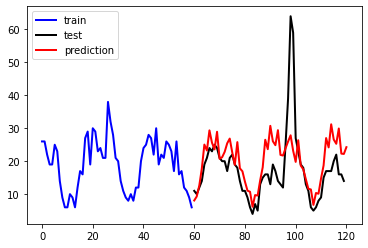

In [ ]:
x = np.arange(step*2+1)
n = step + 1
a, = plt.gca().plot(x[0:step], history[-step-n:-n],lw=2, c = 'blue', label = 'train')
t, = plt.gca().plot(x[-step-1:-1], test_X[0:step],lw=2, c = 'black', label = 'test')
p, = plt.gca().plot(x[-step-1:],prediction,lw=2,c='red',label='prediction')
plt.legend(handles=[a,t,p])

In [ ]:
from sklearn.metrics import mean_squared_error
#Print MSE to see how good the model is
o = int(len(prediction))
Error = mean_squared_error(test_X[1:o+1],prediction)
print('Test Mean Squared Error (Lane 1): %.3f' %Error)

Test Mean Squared Error (Lane 1): 82.298


In [ ]:
X2,y2 = df_ln2.values, df_ln2.end_index
train_X2, test_X2, train_y2, test_y2 = X2[0:size], X2[size:len(X2)], y2[0:size], y2[size:len(y2)]

AttributeError: ignored

In [ ]:
interval = 24
differenced2 = difference(train_X2, interval)

In [ ]:
fig,ax = plt.subplots(2,1,figsize(20,10))
fig = sm.graphics.tsa.plot_acf(differenced2, lags = 100, ax = ax[0])
fig = sm.graphics.tsa.plot_pacf(differenced, lags = 100, ax = ax[1])
plt.show()

In [ ]:
#fit arma_order_select_ic
model = ARIMA(differenced, order=(4,0,4)).fit()
model_fit =  model.fit(disp=0)
# multi-step out of sample forecast
step = 60
start_index = len(differenced2)
end_index = start_index + steps
forecast2 = model_fit.predict(start =  start_index, end = end_index)
# invert the differenced forecast to something usable
history2 = [x for x in train_X]
prediction2 = []
for yhat in forecast:
    inverted2 = inverse_difference(history2, yhat, interval)
    history2.append(inverted2)
    predictions2.append(inverted2)


In [ ]:
x = np.arrange(steps*2+1)
n = steps + 1
a, = plt.gca().plot(x[0:steps], history2[-steps-n:-n],lw=2, c = 'blue', label = 'train')
t, = plt.gca().plot(x[-steps-1:-1], test_X2[0:steps],lw=2, c = 'blue', label = 'test')
p, = plt.gca().plot(x[-steps-1:],predictions2,lw=2,c='red',label='prediction')
plt.legend(handles=[a,t,p])

In [ ]:
o = int(len(predictions2))
Error = mean_squared_error(test_X2[1:o+1],predctions2)
print('Test Mean Squared Error (Lane 2): %.3f' %Error)

In [ ]:
import statsmodels.api as sm
resDiff = sm.tsa.arma_order_select_ic(train_X, max_ar=5, max_ma=5, ic='aic', trend = 'c')
print('ARMA(p,q)=', resDiff['aic_min_order'], 'is the best.')